In [2]:
from __future__ import division
import ipyparallel as ipp
import numpy as np
from numpy import array
from numpy.random import sample as rs
from numpy import newaxis as na
import pandas as pd 
from scipy.stats import distributions
from scipy.stats import sem
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from radd.rl import multirace, analyzer, visr
from radd.tools import theta
from scipy.stats import pearsonr

homedir = os.path.expanduser('~')
cards = pd.read_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/IGTCards.csv"))
cards_scaled=cards.copy()*.01
cards_normed = (cards-cards.mean().mean())/cards.std().mean()

datadf = pd.read_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/IGT_data.csv"))
dat = datadf.dropna()

In [3]:
multirace=reload(multirace)

In [4]:
p={'vd':.7, 'vi':.3, 'a':.35, 'tr':.2, 'xb': .5}
env = cards_scaled.copy()
ago = np.array([.05, .1, .25])
ano = np.array([.05, .1, .25])
a_go = np.tile(ago, ano.size)
a_no = np.sort(np.tile(ano, ago.size))

In [8]:
trialdf, igtdf = run_full_sims(p, env=env, alphas_go=a_go, alphas_no=a_no, nagents=150)

 aG: 0.05
 aN: 0.05


 aG: 0.1
 aN: 0.05


 aG: 0.25
 aN: 0.05


 aG: 0.05
 aN: 0.1


 aG: 0.1
 aN: 0.1


 aG: 0.25
 aN: 0.1


 aG: 0.05
 aN: 0.25


 aG: 0.1
 aN: 0.25


 aG: 0.25
 aN: 0.25




In [7]:
def run_full_sims(p, env=pd.DataFrame, alphas_go=[], alphas_no=None, betas=[], nblocks=2, nagents=20, si=.01, agent_list=[]):
    from scipy.stats.distributions import uniform
    alpha_groups = range(alphas_go.size)
    agents = range(1, nagents+1)
    trials = np.arange(1, (len(env)*nblocks)+1)
    for agroup in alpha_groups:
        a_go = alphas_go[agroup]
        a_no = alphas_no[agroup]
        print(' aG: {0}\n aN: {1}\n\n'.format(a_go, a_no))
        for agent_i in agents:
            beta = uniform.rvs(1.5, 6.5)
            pcopy=deepcopy(p)
            sim_out = multirace.run_trials(pcopy, env, nblocks=nblocks, si=si, a_go=a_go, a_no=a_no, beta=beta)
            choices, rts, all_traces, qdict, choicep, vd_all, vi_all = sim_out
            format_dict = {'agent': agent_i, 'trial': trials, 'a_go': a_go, 'a_no': a_no,
            'adiff': a_go-a_no, 'choices':choices, 'rts': rts, 'agroup': agroup,
            'qdict': qdict, 'choicep': choicep, 'vd_all':vd_all, 'vi_all':vi_all,
            'beta': beta}
            format_dict_updated = analyzer.analyze_learning_dynamics(format_dict)
            igtdf, agdf = analyzer.format_dataframes(format_dict_updated)
            agent_list.append([agdf, igtdf])

    trial_df = pd.concat([ag[0] for ag in agent_list]) #.groupby(['group', 'trial']).mean().reset_index()
    igt_df = pd.concat([ag[1] for ag in agent_list], axis=1).T #.groupby('group').mean().reset_index()
    return [trial_df, igt_df]


In [417]:
igtdf = igtdf.copy()
for col in ['beta']:
    for row in xrange(igtdf.shape[0]):
        igtdf.loc[row, col] = np.mean(igtdf.loc[row, col])
igtdf = igtdf.convert_objects(convert_numeric=True)

/Users/kyle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [9]:
idf = igtdf.groupby(['agroup']).mean()
idf.reset_index(inplace=True)
idf_ano = idf['a_no'].unique()

tdf = trialdf.groupby(['trial', 'agroup']).mean()
tdf.reset_index(inplace=True)
tdf_ano = tdf['a_no'].unique()

lowtdf = tdf[tdf.a_no==tdf_ano[0]]
lowigt = idf[idf.a_no==idf_ano[0]]

medtdf = tdf[tdf.a_no==tdf_ano[1]]
medigt = idf[idf.a_no==idf_ano[1]]

hitdf = tdf[tdf.a_no==tdf_ano[2]]
hiigt = idf[idf.a_no==idf_ano[2]]

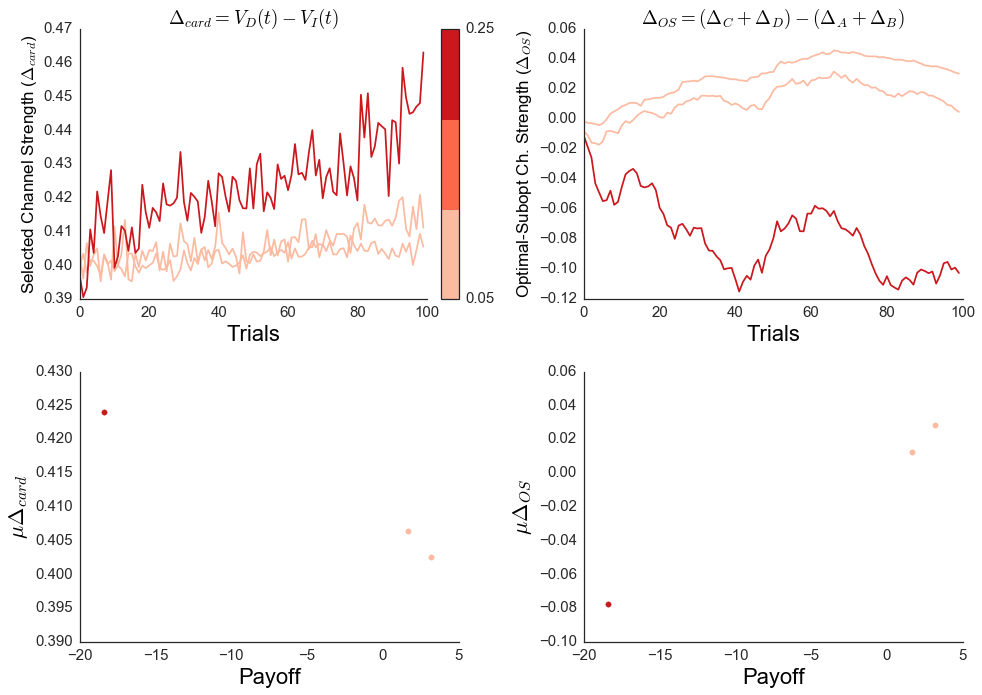

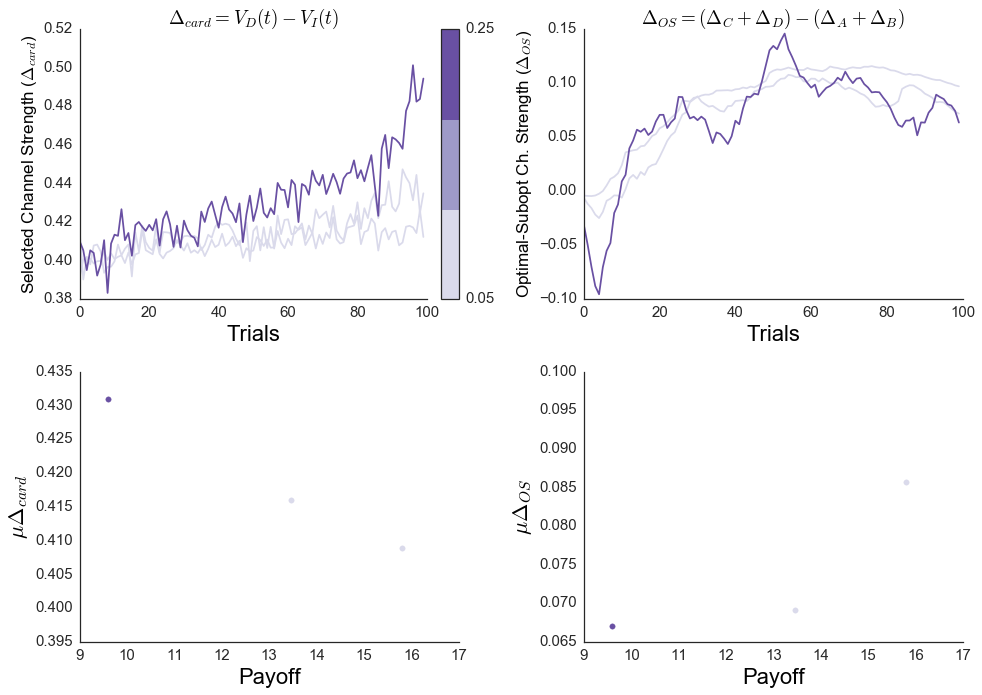

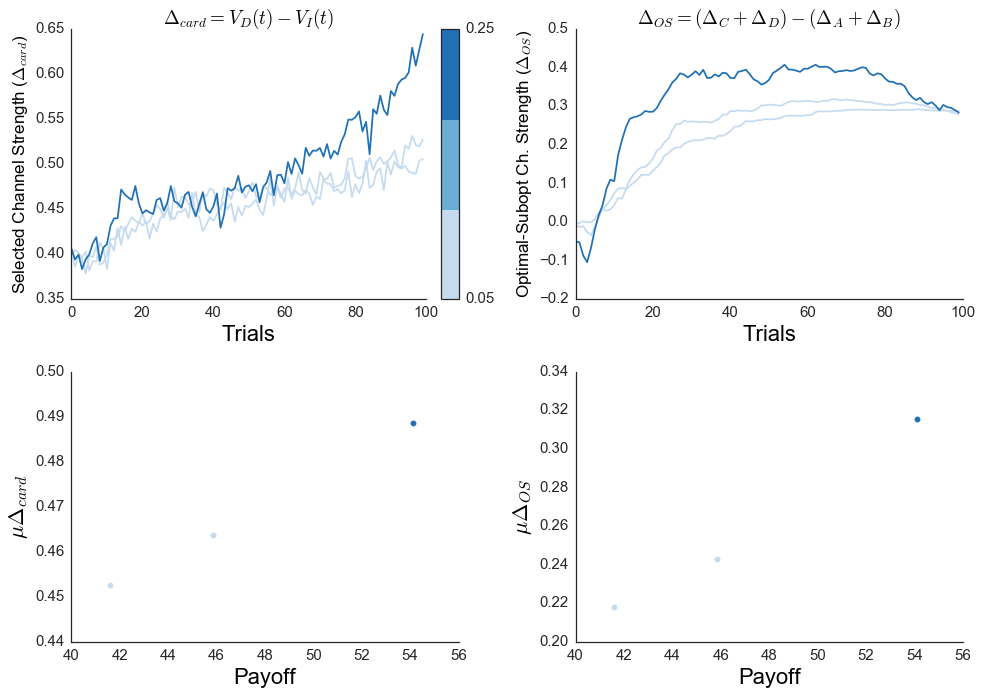

In [10]:
visr.plot_reactivity_strategy(lowtdf, lowigt, cm='Reds')#, save=True)
visr.plot_reactivity_strategy(medtdf, medigt, cm='Purples')#, save=True)
visr.plot_reactivity_strategy(hitdf, hiigt, cm='Blues')#, save=True)


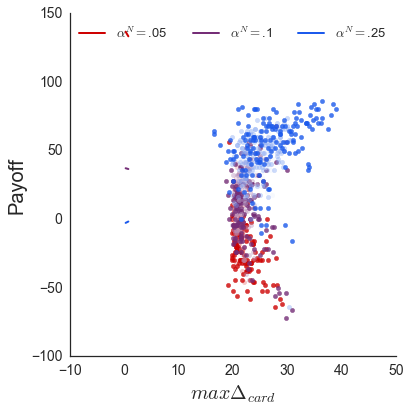

In [23]:
vdiff = [df.pivot_table('vdiff', 'agent', 'a_go', aggfunc=np.sum) for no, df in trialdf[trialdf.trial>=50].groupby('a_no')]
pvals = [df.pivot_table('P', 'agent', 'a_go') for no, df in igtdf.groupby('a_no')]

anos = trialdf[trialdf.trial>=50].a_no.unique()
agos = trialdf[trialdf.trial>=50].a_go.unique()
n_ano = len(anos)
n_ago = len(agos)
#n_beta = trialsdf.beta.unique().size

#f, axes = plt.subplots(1, 3, figsize=(15,4))
f, ax = plt.subplots(1, figsize=(6,6))
sns.set(style='white', font_scale=1.4)
clrs = sns.blend_palette(["#CE0202",  "#1C5AEC"], n_colors=n_ano)
cmaps = [sns.light_palette(ccc, n_colors=n_ago)[-n_ago:] for ccc in clrs]
lbls=["$\\alpha^N=$"+str(nval)[1:] for nval in anos]
xl = []
#scalar = [[.3, .8]]*3#, [.2, .8], [.2, .9]]
alphas= [.3, .4, .8]
aNlist = [0, 1, 2]
aGlist = [0, 1, 2]
for i in aNlist:
    #ax = np.array(axes).flatten()[i]
    for col in aGlist:
        x = vdiff[i].iloc[:, col].values
        y = pvals[i].iloc[:, col].values
        ax.scatter(x, y, color=cmaps[i][col], alpha=alphas[col])
#         par = np.polyfit(x, y, 1, full=True)
#         slope=par[0][0]
#         intercept=par[0][1]
#         #xl = [scalar[i][0], scalar[i][1]]
#         xl = [x.min(), x.max()]
#         yl = [slope*xx + intercept  for xx in xl]
#         ax.plot(xl, yl, color=cmaps[i][col], lw=2)
for i in aNlist:
    #ax = np.array(axes).flatten()[i]
    x = vdiff[i].iloc[:, aGlist].values.flatten()
    y = pvals[i].iloc[:, aGlist].values.flatten()
    #ax.scatter(x, y, color=cmaps[i][-1], alpha=.5)
    par = np.polyfit(x, y, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    xl = [scalar[i][0], scalar[i][1]]
    #xl = [x.min(), x.max()]
    yl = [slope*xx + intercept  for xx in xl]
    ax.plot(xl, yl, color=cmaps[i][col], lw=2, label=lbls[i])        
sns.despine()
# ax.set_xlim(0.3, .8)
# ax.set_ylim(-80, 120)
ax.legend(loc='upper center', ncol=3, fontsize=13)    
ax.set_ylabel('Payoff', fontsize=20)
ax.set_xlabel('$max\Delta_{card}$', fontsize=20)
plt.tight_layout()

# f.savefig('/Users/kyle/Dropbox/Payoff_by_SUMVDiff_v3.svg', dpi=600, rasterized=True)
# f.savefig('/Users/kyle/Dropbox/Payoff_by_SUMVDiff_v3.eps', dpi=600, rasterized=True)
# f.savefig('/Users/kyle/Dropbox/Payoff_by_SUMVDiff_v3.png', dpi=600)

# f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_v3.svg', dpi=600, rasterized=True)
# f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_v3.eps', dpi=600, rasterized=True)
# f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_v3.png', dpi=600)

# f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_HiLoOnly.svg', dpi=600, rasterized=True)
# f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_HiLoOnly.eps', dpi=600, rasterized=True)
# f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_HiLoOnly.png', dpi=600)

# f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_HiMedOnly.svg', dpi=600, rasterized=True)
# f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_HiMedOnly.eps', dpi=600, rasterized=True)
# f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_HiMedOnly.png', dpi=600)



(-100, 100)

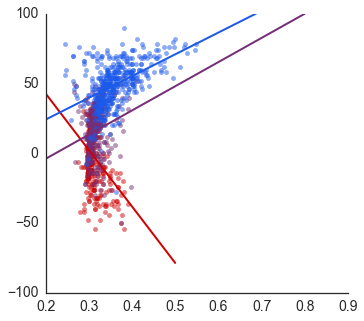

In [447]:
f, ax = plt.subplots(1, figsize=(6,5))
for i in range(n_ano):
    #ax = np.array(axes).flatten()[i]
    x = vdiff[i].values.flatten()
    y = pvals[i].values.flatten()
    ax.scatter(x, y, color=cmaps[i][col], alpha=.5)
    par = np.polyfit(x, y, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    xl = [scalar[i][0], scalar[i][1]]
    yl = [slope*xx + intercept  for xx in xl]
    ax.plot(xl, yl, color=cmaps[i][col], lw=2)

        
        #sns.regplot(x, y, color=cmaps[i][col], ax=ax)
        #xnorm = (x - x.mean())/x.std()
        #ynorm = (y - y.mean())/y.std()
#         for ii, (xx, yy) in enumerate(zip(x, y)):
#             ax.scatter(xx, yy, color=cmaps[i][col], s=30)    
        #if i in [0,3,6] and row==(n_beta-1):
    #         if row==(n_beta-1):
    #             lbl=lbls[i]
    #             lkws = {"lw":2, 'alpha':1}
        
    #         else:
    #             lbl=None;
    #             lkws = {"lw":1, 'alpha':.5

sns.despine()
#ax.legend(loc='upper center', ncol=3)    
#plt.tight_layout()
#ax.set_ylabel('Payoff', fontsize=20)
#ax.set_xlabel('$\mu\Delta_{card}$', fontsize=20)
ax.set_xlim(0.2, .9)
ax.set_ylim(-100, 100)

In [258]:
f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_v2.svg', dpi=600, rasterized=True)
f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_v2.eps', dpi=600, rasterized=True)
f.savefig('/Users/kyle/Dropbox/Payoff_by_muVDiff_v2.png', dpi=600)

In [217]:
slope=par[0][0]
intercept=par[0][1]
xl = [min(x), max(x)]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl)

In [218]:
plt.plot(xl, yl)

[0.33814709342996124, 0.79302585040900497]

In [209]:
plt.plot(par[0])

(array([ 17.25476,  39.78908]),
 array([ 59266.7771]),
 2,
 array([ 1.40785,  0.13398]),
 2.2204460492503131e-14)

In [4]:
# igt_bygroup = pd.read_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/simulations/igtdf_avg_agent.csv"))
# tdf_bygroup = pd.read_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/simulations/trialsdf_avg_agent.csv"))
igt_bygroup = pd.read_csv('/Users/kyle/Dropbox/Projects/IGTob/simulations/igtdf_avg_agent.csv')
tdf_bygroup = pd.read_csv('/Users/kyle/Dropbox/Projects/IGTob/simulations/trialsdf_avg_agent.csv')

In [7]:
trialsdf = pd.read_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/simulations/trialsdf.csv"))
igtdf = pd.read_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/simulations/igtdf.csv"))

In [8]:
tdf = trialsdf.groupby(['agroup', 'bgroup', 'trial']).mean().reset_index()

In [22]:
lowag = tdf[tdf['a_no']==tdf.a_no.min()]
lowag.a_go.unique()
lowag.beta.unique()a
#tdf.head()

array([ 5.  ,  5.75,  6.5 ,  7.25,  8.  ])

In [60]:
#ncolors = tdf_bygroup.agroup.unique().size
ncolors = tdf.a_no.unique().size
clrs = sns.blend_palette(["#CE0202",  "#1C5AEC"], n_colors=ncolors)


In [9]:
sm, vmin, vmax = visr.gen_mappable(tdf_bygroup.agroup.unique(), clrs)

(<matplotlib.cm.ScalarMappable at 0x7f6fcb5b7910>, 1.0, 90.0)

In [16]:
nago

array([ 0.01   ,  0.09069,  0.17138,  0.25207,  0.31259,  0.33276,
        0.19155,  0.21172,  0.29241,  0.3731 ,  0.05034,  0.13103])

In [17]:
ano

0.01

In [5]:
tdf = tdf_bygroup.groupby(['agroup', 'trial']).mean().reset_index()
igtdf = igt_bygroup.groupby(['agroup', 'bgroup']).mean().reset_index()

In [6]:
tdf.bgroup.unique()
tdf_b5 = tdf[tdf.bgroup==1]

In [95]:
r=plot_reactivity_strategy(ano_df, idf, cm=c, pq='Q')

In [129]:
x = tdf_b5[tdf_b5.a_no==tdf_b5.a_no.unique()[0]]
x.a_go.unique()

array([ 0.01   ,  0.05034,  0.09069,  0.13103,  0.17138,  0.21172,
        0.25207,  0.29241,  0.33276,  0.3731 ])

In [101]:
igtdf.a_no.unique()[i]

0.01

In [125]:
#f, ax = plt.subplots(figsize=(7,6))
pads = [.01, .5, .9]
saves = [0, 0, 0]

for i, (ano, andf) in enumerate(tdf_b5.groupby('a_no')):
    ano_df = andf.groupby(['a_go', 'trial']).mean().reset_index()
    nago = ano_df.a_go.unique().size
    idf = igtdf[igtdf.a_no==igtdf.a_no.unique()[i]]
    c = sns.light_palette(clrs[i], n_colors=nago)
    plot_reactivity_strategy(ano_df, idf, cm=c, pq='Q')
    

IndexError: index 8 is out of bounds for axis 0 with size 8

In [126]:
def plot_reactivity_strategy(trialsdf, igtdf, cm='rainbow', ax=None, save=False, pq='P', pad=.2):

    if pq=='P':
        measure = 'Payoff'
    else:
        measure = 'Sensitivity'

    n = trialsdf.a_go.unique().size
    a_go = np.sort(trialsdf.a_go.unique())
    sm, vmin, vmax = visr.gen_mappable(vals_to_map=a_go, cm=cm)
    
    if ax is None:
        f, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
    

    for i, (grp, grpdf) in enumerate(trialsdf.groupby('a_go')):
        if grp==a_go[-1]:
            axtext = "$\\alpha^N = $"
            ano_str = str(trialsdf.a_no.unique()[0])
            label = axtext+ano_str
        else:
            label=None
        colr = sm.to_rgba(a_go[i])
        ax.plot(grpdf.vdiff.values, color=colr, label=label)
        sns.despine()
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.2)
    cb = plt.colorbar(sm, cax)
    sm.colorbar.set_ticks([vmin, vmax])
    #cax.set_yticklabels([vmin, vmax])
    cax.set_yticklabels([])
    
    pvals_by_group = igtdf.groupby('a_go').mean().loc[:, 'P'].values
    qvals_by_group = igtdf.groupby('a_go').mean().loc[:, 'Q'].values
    reactivity = np.array([grpdf.vdiff.mean() for grp, grpdf in trialsdf.groupby('a_go')])
    
    #strategy = np.array([grpdf.v_opt_diff.mean() for grp, grpdf in trialsdf.groupby('a_go')])
    

    for i in range(n):
        colr = sm.to_rgba(a_go[i])
        ax2.scatter(reactivity[i], pvals_by_group[i], color=colr, s=30)
        ax3.scatter(reactivity[i], qvals_by_group[i], color=colr, s=30)
        
    ax.set_title('$\Delta_{card} = V_{D}(t)-V_{I}(t)$', fontsize=19)
    ax.set_ylabel('Selected Channel Strength ($\Delta_{card}$)', fontsize=17)
    ax.set_xlabel('Trials', fontsize=19)
    ax2.set_xlabel('$\Delta_{card}$')
    ax3.set_xlabel('$\Delta_{card}$')
    ax2.set_ylabel('Payoff')
    ax3.set_ylabel('Sensitivity')
    #yix = grpdf.vdiff.values[-3]
    #axtext = "$\\alpha^N = $"
    #ano_str = str(trialsdf.a_no.unique()[0])
    #ax.text(4, .85, axtext+ano_str, fontsize=18)
    ax.legend(loc=2, fontsize=15)
    plt.tight_layout()
    #ax.set_ylim(.1, 1.05)
    if save:
        f = plt.gcf()
        os.chdir(os.path.join(homedir, "Dropbox/"))
        save_str = 'reactivity_strategy_%s' % measure
        f.savefig('.'.join([save_str, 'png']), dpi=1200)
        f.savefig('.'.join([save_str, 'svg']), dpi=1200)
        f.savefig('.'.join([save_str, 'eps']), dpi=1200)

In [38]:
env = cards_scaled.copy()

In [39]:
nagents=20
nblocks=2

In [40]:
ago = np.linspace(.01, .4, 30)
#ano = np.array([.2,])
ano = ago #np.array([.01, .2, .4])
alphas_go = np.tile(ago, ano.size)
alphas_no = np.tile(ano, ago.size)
#betas = np.linspace(.1, 8, 5)
betas = np.array([5])


n_a = len(alphas_go)
n_b = len(betas)
trials = np.arange(1, (len(env)*nblocks)+1)

if alphas_no is None:
    alphas_no=deepcopy(alphas_go)

agroups = np.hstack([np.hstack([np.arange(n_a)]*n_b)]*nagents)
bgroups = np.hstack([np.sort(np.hstack([np.arange(n_b)]*n_a))]*nagents)
agents = np.sort(np.hstack([np.arange(nagents)]*n_a*n_b))


In [44]:
agents

array([ 0,  0,  0, ..., 19, 19, 19])

In [29]:
def run_parameter_set(env, p={'vd':.7, 'vi':.4, 'a':.4, 'tr':.2, 'xb': 1.5}):
    
    from radd.rl import multirace
    multirace=reload(multirace)
    nagents=20
    
    ago = np.linspace(.01, .4, 30)
    ano = np.array([.01, .2, .4])
    
    a_go = np.tile(ago, ano.size)
    a_no = np.tile(ano, ago.size)
    betas = np.linspace(5, 8, 5)
    #betas = np.array([5])
    
    df1, df2 = multirace.run_full_sims(p, env=env, alphas_go=a_go, alphas_no=a_no, betas=betas, nagents=nagents)
    return [df1, df2]


def unique_agents_per_PID(alldfs):    
    i=1
    for tdf in alldfs[1:]:
        df = tdf.copy()
        agent_vals = alldfs[i-1].agent.values.max() + df.agent.values
        df['agent']=agent_vals
        alldfs[i]=df
        i+=1
        
    return alldfs

# Initialize Process Handler

In [30]:
c = ipp.Client()

# Parallelize simulations of $\alpha, \beta$ across nagents

In [31]:
dataframes = c[:].apply_sync(run_parameter_set, cards_scaled.copy())

In [40]:
tdf_all = [dfs[0].copy() for dfs in dataframes]
igdf_all = [dfs[1].copy() for dfs in dataframes]

tdf = pd.concat(tdf_all)
igdf = pd.concat(igdf_all)

#tdf.to_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/trialsdf.csv"), index=False)
#igdf.to_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/igtdf.csv"))

In [36]:
alldfs = unique_agents_per_PID(tdf_all)
trialsdf = pd.concat(alldfs)
igtdf=pd.concat(igdf_all)
agents_by_group = np.hstack([tdf_all[i].agent.unique() for i in range(len(c))]*int(igtdf.group.max()))
igtdf['agent'] = agents_by_group

In [39]:
igtdf.to_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/igtdf.csv"), index=False)

In [41]:
tdf_bygroup = trialsdf.groupby(['group', 'trial']).mean().reset_index()
igt_bygroup = igtdf.groupby('group').mean().reset_index()
abeta_by_no = [nodf.pivot_table('P', 'a_go', 'beta') for no, nodf in igt_bygroup.groupby('a_no')]

In [43]:
igt_bygroup.to_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/igtdf_avg_agent.csv"), index=False)
tdf_bygroup.to_csv(os.path.join(homedir, "Dropbox/Projects/IGTob/trialsdf_avg_agent.csv"), index=False)

In [46]:
#ano_df = igtdf.copy()
ano_df = igtdf[igtdf.a_no.isin([.01, .05, .1, .2, .4])]
abeta_by_no = [nodf.pivot_table('P', 'a_go', 'beta') for no, nodf in ano_df.groupby('a_no')]

anos = ano_df.a_no.unique()[::-1]
agos = ano_df.a_go.unique()[::2]
n_ano = len(anos)
n_ago = len(agos)

clrs = sns.blend_palette(["#CE0202",  "#1C5AEC"], n_colors=n_ano)
cmaps = [sns.light_palette(ccc, input='hex', n_colors=n_ago+5)[-n_ago:] for ccc in clrs][::-1]

ylpos = [-80, 90]
ylneg = [-80, 80]

f, axes = plt.subplots(1,n_ano,figsize=(17,4))
sns.set(style='white', font_scale=1.4)

for i, df in enumerate(abeta_by_no[::-1]):
    ax=axes.flatten()[i]
    df.iloc[::2, :].T.plot(color=cmaps[i], ax=ax, legend=False, linewidth=2)
    ax.set_title("$\\alpha^N = {0}$".format(str(anos[i])), fontsize=17)
    ax.set_xlabel('Inv. Temp (' + "$\\beta$"+")")
    if i<3:
        ax.set_ylim(ylpos[0], ylpos[1])
    else:
        ax.set_ylim(ylneg[0], ylneg[1])
    if i==0:
        ax.set_ylabel('Payoff')
    ax.hlines(y=0, xmin=0, xmax=8, color='#222222', linestyles='--') 

sns.despine()
plt.tight_layout()    

#f.savefig('/home/kyle/Dropbox/Projects/IGTob/rlRADD_IGT_Figures/payoff2d_aG_beta_aN.svg', rasterized=True, dpi=600)
#f.savefig('/home/kyle/Dropbox/Projects/IGTob/rlRADD_IGT_Figures/payoff2d_aG_beta_aN.eps', rasterized=True, dpi=600)
#f.savefig('/home/kyle/Dropbox/Projects/IGTob/rlRADD_IGT_Figures/payoff2d_aG_beta_aN.png', dpi=600)

In [222]:
#ano_df = igtdf.copy()
ano_df = igtdf[igtdf.a_no.isin([.01, .05, .1, .2, .4])]
abeta_by_no = [nodf.pivot_table('P', 'a_go', 'beta') for no, nodf in ano_df.groupby('a_no')]

anos = ano_df.a_no.unique()[::-1]
agos = ano_df.a_go.unique()[::2]
n_ano = len(anos)
n_ago = len(agos)

clrs = sns.blend_palette(["#CE0202",  "#1C5AEC"], n_colors=n_ano)
cmaps = [sns.light_palette(ccc, input='hex', n_colors=n_ago+3)[-n_ago:] for ccc in clrs][::-1]

ylpos = [-80, 90]
ylneg = [-80, 80]

f, axes = plt.subplots(1,n_ano,figsize=(17,4))
sns.set(style='white', font_scale=1.4)

for i, df in enumerate(abeta_by_no[::-1]):
    ax=axes.flatten()[i]
    df.iloc[::2, :].T.plot(color=cmaps[i], ax=ax, legend=False, linewidth=2)
    ax.set_title("$\\alpha^N = {0}$".format(str(anos[i])), fontsize=17)
    ax.set_xlabel('Inv. Temp (' + "$\\beta$"+")")
    if i<3:
        ax.set_ylim(ylpos[0], ylpos[1])
    else:
        ax.set_ylim(ylneg[0], ylneg[1])
    if i==0:
        ax.set_ylabel('Payoff')
    ax.hlines(y=0, xmin=0, xmax=8, color='#222222', linestyles='--') 

sns.despine()
plt.tight_layout()    

#f.savefig('/home/kyle/Dropbox/Projects/IGTob/rlRADD_IGT_Figures/payoff2d_aG_beta_aN.svg', rasterized=True, dpi=600)
#f.savefig('/home/kyle/Dropbox/Projects/IGTob/rlRADD_IGT_Figures/payoff2d_aG_beta_aN.eps', rasterized=True, dpi=600)
#f.savefig('/home/kyle/Dropbox/Projects/IGTob/rlRADD_IGT_Figures/payoff2d_aG_beta_aN.png', dpi=600)

In [70]:
trialsdf.agent.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

LinAlgError: Arrays cannot be empty

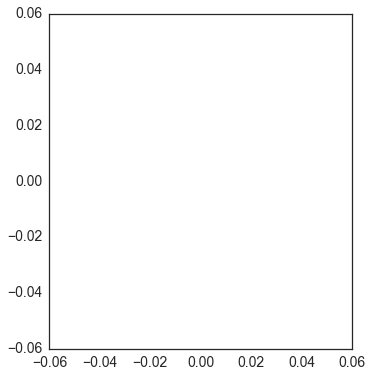

In [181]:
vdiff = [df.pivot_table('vdiff', 'beta', 'a_go') for no, df in trialdf.groupby('a_no')]
pvals = [df.pivot_table('P', 'beta', 'a_go') for no, df in igtdf.groupby('a_no')]

anos = trialdf.a_no.unique()
agos = trialdf.a_go.unique()
n_ano = len(anos)
n_ago = len(agos)
n_beta = trialdf.beta.unique().size

f, ax = plt.subplots(1, figsize=(6,6))
sns.set(style='white', font_scale=1.4)
clrs = sns.blend_palette(["#CE0202",  "#1C5AEC"], n_colors=n_ano)
cmaps = [sns.light_palette(ccc, n_colors=n_ago+2)[-n_ago:] for ccc in clrs]
lbls=["$\\alpha^N=$"+str(nval) for nval in anos]

for i in range(n_ano):
    for row in range(n_beta):
        x = vdiff[i].iloc[row, :]
        y = pvals[i].iloc[row, :]
        xnorm = (x - x.mean())/x.std()
        ynorm = (y - y.mean())/y.std()
        for ii, (xx, yy) in enumerate(zip(xnorm, ynorm)):
            ax.scatter(xx, yy, color=cmaps[i][ii], s=30)    
        #if i in [0,3,6] and row==(n_beta-1):
        if row==(n_beta-1):
            lbl=lbls[i]
            lkws = {"lw":2, 'alpha':1}
        else:
            lbl=None;
            lkws = {"lw":1, 'alpha':.5}
        sns.regplot(xnorm, ynorm, color=clrs[i], label=lbl, scatter=0, ax=ax, ci=0, line_kws=lkws)
    
sns.despine()
ax.legend(loc='upper center', ncol=3)    
plt.tight_layout()
ax.set_ylabel('Payoff', fontsize=20)
ax.set_xlabel('$\mu\Delta_{card}$', fontsize=20)

#f.savefig('/home/kyle/Dropbox/Payoff_by_muVDiff_HML_aN.svg', dpi=600, rasterized=True)
#f.savefig('/home/kyle/Dropbox/Payoff_by_muVDiff_HML_aN.eps', dpi=600, rasterized=True)
#f.savefig('/home/kyle/Dropbox/Payoff_by_muVDiff_HML_aN.png', dpi=600)

In [49]:
tdfhml.a_no.unique()

array([ 0.01,  0.4 ])

In [50]:
hml

array([ 0.01,  0.4 ])

In [51]:
tdfhml = trialsdf[trialsdf.a_go.isin(hml)]
igthml = igtdf[igtdf.a_go.isin(hml)]

In [88]:
hml=agos[[0, 16, -1]]
tdfhml = trialsdf[trialsdf.a_go.isin(hml)]
igthml = igtdf[igtdf.a_go.isin(hml)]
anos = tdfhml.a_no.unique()[::-1]
agos = tdfhml.a_go.unique()
# anos = trialsdf.a_no.unique()[::-1]
# agos = trialsdf.a_go.unique()
n_ano = len(anos)
n_ago = len(agos)
n_beta = trialsdf.beta.unique().size

In [89]:
vdiff = [df.pivot_table('vdiff', 'beta', 'a_go') for no, df in tdfhml.groupby('a_no')]
pvals = [df.pivot_table('P', 'beta', 'a_go') for no, df in igthml.groupby('a_no')]

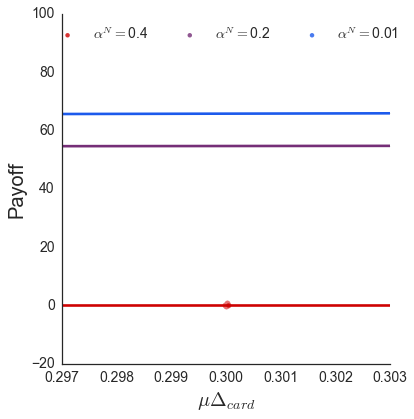

In [90]:
f, ax = plt.subplots(1, figsize=(6,6))
sns.set(style='white', font_scale=1.4)
clrs = sns.blend_palette(["#CE0202",  "#1C5AEC"], n_colors=n_ano)
cmaps = [sns.light_palette(ccc, n_colors=n_ago+2)[-n_ago:] for ccc in clrs]
lbls=["$\\alpha^N=$"+str(nval) for nval in anos]

for i in range(n_ano):
    for row in range(n_beta):
        x = vdiff[i].iloc[row, :]
        y = pvals[i].iloc[row, :]
#     x = (x - x.mean())/x.std()
#     y = (y - y.mean())/y.std()
        for ii, (xx, yy) in enumerate(zip(x, y)):
            ax.scatter(xx, yy, color=cmaps[i][ii], s=30)    
#     if i in [0,3,6] and row==(n_beta-1):
        if row==(n_beta-1): 
            lbl=lbls[i]
            sns.regplot(x, y, color=clrs[i], label=lbls[i], scatter=True, ax=ax)
        else: 
            pass


    
#     sns.regplot(x, y, color=clrs[i], label=lbls[i], scatter=True, ax=ax)#, ci=0, line_kws=lkws)
    
sns.despine()
#ax.set_ylim(0, 100)
ax.legend(loc='upper center', ncol=3)    
plt.tight_layout()
ax.set_ylabel('Payoff', fontsize=20)
ax.set_xlabel('$\mu\Delta_{card}$', fontsize=20)

#f.savefig('/home/kyle/Dropbox/Payoff_by_muVDiff_HML_aN.svg', dpi=600, rasterized=True)
#f.savefig('/home/kyle/Dropbox/Payoff_by_muVDiff_HML_aN.eps', dpi=600, rasterized=True)
#f.savefig('/home/kyle/Dropbox/Payoff_by_muVDiff_HML_aN.png', dpi=600)

In [124]:

abeta_by_no = [nodf.pivot_table('P', 'a_go', 'beta') for no, nodf in igtdf.groupby('a_no')]

py.offline.init_notebook_mode() # run at the start of every notebook
datam = [go.Surface(x=data.columns.values, y=data.index.values, z=data.as_matrix()) for data in abeta_by_no]
py.iplot(go.Figure(data=datam))

# Single Sim

In [114]:
p={'vd':.7, 'vi':.4, 'a':.4, 'tr':.2, 'xb': 1.5}

pdict = theta.random_inits(['vd', 'vi', 'tr', 'a', 'xb'])

p = deepcopy(pdict)
output = multirace.run_trials(p, cards_scaled, nblocks=2, si=.01, a_go=.25, a_no=.01, beta=3)
choices, rts, all_traces, qdict, choice_prob, vdhist, vihist = output
Pi,Qi = analyzer.igt_scores(np.asarray(choices))
visr.plot_reactivity_strategy(output)